# Feature Extraction

In [1]:
import glob
import numpy as np
import vggish_input

all_examples = []

for f in glob.glob("sounds/healthy/*"):
    ex = vggish_input.wavfile_to_examples(f);
    all_examples.append(np.reshape(ex[10:], (10, 96, 64, 1)))
    all_examples.append(np.reshape(ex[-10:], (10, 96, 64, 1)))
    
for f in glob.glob("sounds/copd/*"):
    ex = vggish_input.wavfile_to_examples(f);
    all_examples.append(np.reshape(ex[10:], (10, 96, 64, 1)))
    all_examples.append(np.reshape(ex[-10:], (10, 96, 64, 1)))
    
all_examples = np.array(all_examples)

healthy_labels = np.array([[1, 0]] * 70)
copd_labels = np.array([[0, 1]] * 70)
all_labels = np.concatenate((healthy_labels, copd_labels))

# shuffle all

In [8]:
from random import shuffle

labeled_examples = list(zip(all_examples, all_labels))
shuffle(labeled_examples)

features = np.array([example for (example, _) in labeled_examples])
labels = np.array([label for (_, label) in labeled_examples])

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import vggish_params

vggish_model = Sequential()

# Block 1
vggish_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1', input_shape=(vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1), trainable=False))
vggish_model.add(MaxPooling2D(padding='same', name='pool1'))

# Block 2
vggish_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2', trainable=False))
vggish_model.add(MaxPooling2D(padding='same', name='pool2'))

# Block 3
vggish_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3/conv3_1', trainable=False))
vggish_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3/conv3_2', trainable=False))
vggish_model.add(MaxPooling2D(padding='same', name='pool3'))

# Block 4
vggish_model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4/conv4_1', trainable=False))
vggish_model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4/conv4_2', trainable=False))
vggish_model.add(MaxPooling2D(padding='same', name='pool4'))

# FC block
vggish_model.add(Flatten(name='flatten_'))
vggish_model.add(Dense(4096, activation='relu', name='fc1/fc1_1', trainable=False))
vggish_model.add(Dense(4096, activation='relu', name='fc1/fc1_2', trainable=False))
vggish_model.add(Dense(vggish_params.EMBEDDING_SIZE, activation='relu', name='fc2', trainable=False))

vggish_model.load_weights('vggish_model.h5', by_name=True)

In [5]:
from tensorflow.keras.layers import TimeDistributed, Bidirectional, GRU
from tensorflow.keras import optimizers

model = Sequential()
model.add(TimeDistributed(vggish_model, input_shape=(10, vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1)))
model.add(Bidirectional(GRU(128)))
model.add(Dense(2, activation='softmax'))

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 128)           72141184  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               198144    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 72,339,842
Trainable params: 198,658
Non-trainable params: 72,141,184
_________________________________________________________________
None


In [9]:
history = model.fit(features, labels, epochs=50, batch_size=16, validation_split=0.15)
model.save_weights('vggish-bigru-model.h5', overwrite=True)

Train on 119 samples, validate on 21 samples
Epoch 1/50
119/119 [==============================] - 16s 136ms/sample - loss: 0.6939 - acc: 0.5126 - val_loss: 0.6935 - val_acc: 0.3810
Epoch 2/50
119/119 [==============================] - 3s 21ms/sample - loss: 0.6924 - acc: 0.4958 - val_loss: 0.6893 - val_acc: 0.6190
Epoch 3/50
119/119 [==============================] - 3s 21ms/sample - loss: 0.6915 - acc: 0.4790 - val_loss: 0.6846 - val_acc: 0.6190
Epoch 4/50
119/119 [==============================] - 3s 21ms/sample - loss: 0.6905 - acc: 0.4790 - val_loss: 0.6835 - val_acc: 0.6190
Epoch 5/50
119/119 [==============================] - 3s 21ms/sample - loss: 0.6896 - acc: 0.4790 - val_loss: 0.6810 - val_acc: 0.6190
Epoch 6/50
119/119 [==============================] - 3s 21ms/sample - loss: 0.6889 - acc: 0.4790 - val_loss: 0.6790 - val_acc: 0.6190
Epoch 7/50
119/119 [==============================] - 3s 21ms/sample - loss: 0.6879 - acc: 0.4790 - val_loss: 0.6802 - val_acc: 0.6667
Epoch 8/

Text(0.5, 1.0, 'Loss')

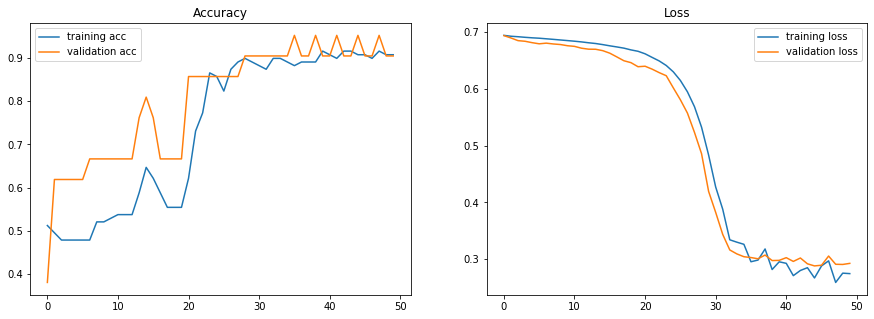

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['acc'], label = 'training acc')
plt.plot(history.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(features)
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(labels, axis = 1)

print(classification_report(labels, predictions, target_names = ['healthy','copd']))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

     healthy       0.85      1.00      0.92        70
        copd       1.00      0.83      0.91        70

    accuracy                           0.91       140
   macro avg       0.93      0.91      0.91       140
weighted avg       0.93      0.91      0.91       140

[[70  0]
 [12 58]]
